In [1]:
!pip install torchsummary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchsummary as summary
import time
import torch
from torch import nn
import torchvision
from torchvision import models,transforms
from torch.utils.data import DataLoader,Dataset
import os
from PIL import Image

In [3]:
!nvidia-smi

Mon Sep  6 02:37:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
class_dict=pd.read_csv("../input/100-bird-species/birds_rev2/class_dict.csv")
class_dict

,class_index,class,height,width,scale by
0,0.0,AFRICAN CROWNED CRANE,224,224,1
1,1.0,AFRICAN FIREFINCH,224,224,1
2,2.0,ALBATROSS,224,224,1
3,3.0,ALEXANDRINE PARAKEET,224,224,1
4,4.0,AMERICAN AVOCET,224,224,1
...,...,...,...,...,...
812,NaN,NaN,224,224,1
813,NaN,NaN,224,224,1
814,NaN,NaN,224,224,1
815,NaN,NaN,224,224,1


In [6]:
bird_data=pd.read_csv("../input/100-bird-species/birds_rev2/birds.csv")
bird_data

,filepaths,labels,data set
0,train/AFRICAN CROWNED CRANE/001.jpg,AFRICAN CROWNED CRANE,train
1,train/AFRICAN CROWNED CRANE/002.jpg,AFRICAN CROWNED CRANE,train
2,train/AFRICAN CROWNED CRANE/003.jpg,AFRICAN CROWNED CRANE,train
3,train/AFRICAN CROWNED CRANE/004.jpg,AFRICAN CROWNED CRANE,train
4,train/AFRICAN CROWNED CRANE/005.jpg,AFRICAN CROWNED CRANE,train
...,...,...,...
42109,valid/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,valid
42110,valid/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,valid
42111,valid/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,valid
42112,valid/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,valid


In [7]:
train_path=os.listdir("../input/100-bird-species/birds_rev2/train")
val_path=os.listdir("../input/100-bird-species/birds_rev2/valid")
test_path=os.listdir("../input/100-bird-species/birds_rev2/test")

In [8]:
a=class_dict['class'].unique()[:-1]
name_dict=dict(zip(a,np.arange(275)))


In [9]:
bird_data['data set'].unique()

array(['train', 'test', 'valid'], dtype=object)

In [10]:
train_pd=bird_data[bird_data['data set']=='train']
train_pd

,filepaths,labels,data set
0,train/AFRICAN CROWNED CRANE/001.jpg,AFRICAN CROWNED CRANE,train
1,train/AFRICAN CROWNED CRANE/002.jpg,AFRICAN CROWNED CRANE,train
2,train/AFRICAN CROWNED CRANE/003.jpg,AFRICAN CROWNED CRANE,train
3,train/AFRICAN CROWNED CRANE/004.jpg,AFRICAN CROWNED CRANE,train
4,train/AFRICAN CROWNED CRANE/005.jpg,AFRICAN CROWNED CRANE,train
...,...,...,...
39359,train/YELLOW HEADED BLACKBIRD/155.jpg,YELLOW HEADED BLACKBIRD,train
39360,train/YELLOW HEADED BLACKBIRD/156.jpg,YELLOW HEADED BLACKBIRD,train
39361,train/YELLOW HEADED BLACKBIRD/157.jpg,YELLOW HEADED BLACKBIRD,train
39362,train/YELLOW HEADED BLACKBIRD/158.jpg,YELLOW HEADED BLACKBIRD,train


In [11]:
val_pd=pd.DataFrame(bird_data[bird_data['data set']=='valid'].values,columns=['filepaths','labels','data set'])
val_pd

,filepaths,labels,data set
0,valid/AFRICAN CROWNED CRANE/1.jpg,AFRICAN CROWNED CRANE,valid
1,valid/AFRICAN CROWNED CRANE/2.jpg,AFRICAN CROWNED CRANE,valid
2,valid/AFRICAN CROWNED CRANE/3.jpg,AFRICAN CROWNED CRANE,valid
3,valid/AFRICAN CROWNED CRANE/4.jpg,AFRICAN CROWNED CRANE,valid
4,valid/AFRICAN CROWNED CRANE/5.jpg,AFRICAN CROWNED CRANE,valid
...,...,...,...
1370,valid/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,valid
1371,valid/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,valid
1372,valid/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,valid
1373,valid/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,valid


In [12]:
test_pd=pd.DataFrame(bird_data[bird_data['data set']=='test'].values,columns=['filepaths','labels','data set'])
test_pd

,filepaths,labels,data set
0,test/AFRICAN CROWNED CRANE/1.jpg,AFRICAN CROWNED CRANE,test
1,test/AFRICAN CROWNED CRANE/2.jpg,AFRICAN CROWNED CRANE,test
2,test/AFRICAN CROWNED CRANE/3.jpg,AFRICAN CROWNED CRANE,test
3,test/AFRICAN CROWNED CRANE/4.jpg,AFRICAN CROWNED CRANE,test
4,test/AFRICAN CROWNED CRANE/5.jpg,AFRICAN CROWNED CRANE,test
...,...,...,...
1370,test/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,test
1371,test/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,test
1372,test/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,test
1373,test/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,test


#计算整个数据集图片的均值和方差
from imageio import imread

filepath = '../input/100-bird-species/birds_rev2'  # 数据集目录

pathDir = train_pd['filepaths']

R_channel = 0
G_channel = 0
B_channel = 0
for idx in range(len(pathDir)):
    filename = pathDir[idx]
    img = imread(os.path.join(filepath, filename))/255.0
    R_channel = R_channel + np.sum(img[:, :, 0])
    G_channel = G_channel + np.sum(img[:, :, 1])
    B_channel = B_channel + np.sum(img[:, :, 2])
 
num = len(pathDir) * 224*224  # 这里（1024,1024）是每幅图片的大小，所有图片尺寸都一样
R_mean = R_channel / num  # or /255.0
G_mean = G_channel / num 
B_mean = B_channel / num 
 
R_channel = 0
G_channel = 0
B_channel = 0
for idx in range(len(pathDir)):
    filename = pathDir[idx]
    img = imread(os.path.join(filepath, filename))/255.0
    R_channel = R_channel + np.sum((img[:, :, 0] - R_mean) ** 2)
    G_channel = G_channel + np.sum((img[:, :, 1] - G_mean) ** 2)
    B_channel = B_channel + np.sum((img[:, :, 2] - B_mean) ** 2)
 
R_var = np.sqrt(R_channel / num)
G_var = np.sqrt(G_channel / num)
B_var = np.sqrt(B_channel / num)
print("R_mean is %f, G_mean is %f, B_mean is %f" % (R_mean, G_mean, B_mean))
print("R_var is %f, G_var is %f, B_var is %f" % (R_var, G_var, B_var))
# R_mean is 0.469289, G_mean is 0.467588, B_mean is 0.393907
# R_var is 0.238269, G_var is 0.232191, B_var is 0.254105

In [13]:
class birddataset(Dataset):
    def __init__(self,in_pd,name_dict,transform):
        self.inpd=in_pd
        self.name_dict=name_dict
        self.transform=transform
    def __len__(self):
        return len(self.inpd)
    def __getitem__(self,idx):
        img=Image.open(os.path.join("../input/100-bird-species/birds_rev2",self.inpd['filepaths'][idx]))
        label=torch.tensor(name_dict[self.inpd['labels'][idx]]).to(device)
        img=transform(img).to(device)
        return img,label

In [14]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.469289, 0.467588, 0.393907), (1,1,1))])

In [15]:
train_dataset=birddataset(train_pd,name_dict,transform)
val_dataset=birddataset(val_pd,name_dict,transform)
test_dataset=birddataset(test_pd,name_dict,transform)


In [16]:
batchsize=256

In [17]:
train_dataloader=DataLoader(train_dataset,batchsize,shuffle=True)
val_dataloader=DataLoader(val_dataset,batchsize,shuffle=True)
test_dataloader=DataLoader(test_dataset,batchsize,shuffle=True)

In [18]:
class resnet18(nn.Module):
    def __init__(self):
        super(resnet18,self).__init__()
        #conv1 112x112
        self.layer1=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        #conv2_x 56x56
        self.layer2=nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        )
        self.layer3=nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
        )
        self.layer4=nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
        )
        #conv3_x 28x28
        self.layer5=nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            
        )
        self.layer6=nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
        )
        #conv4_x 14x14
        self.layer7=nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
        )
        self.layer8=nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
        )
        #con5_x 7*7
        self.layer9=nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
        )
        self.layer10=nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
        )
        #averagepool ,1000-d fc,softmax
        self.layer11=nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(512,275),
        )
        self.se1=nn.Sequential(
            nn.Conv2d(64, 64,kernel_size=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128,kernel_size=1),
            nn.BatchNorm2d(128),
            )
        self.se2=nn.Sequential(
            nn.Conv2d(128, 128,kernel_size=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256,kernel_size=1),
            nn.BatchNorm2d(256),
            )
        self.se3=nn.Sequential(
            nn.Conv2d(256, 256,kernel_size=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512,kernel_size=1),
            nn.BatchNorm2d(512),
            )
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x1=self.layer3(x)
        x=nn.ReLU()(x+x1)#残差1
        x1=self.layer4(x)
        x=nn.ReLU()(x+x1)#残差2
        x1=self.se1(x)
        x=self.layer5(x)
        x=nn.ReLU()(x+x1)#残差3
        x1=self.layer6(x)
        x=nn.ReLU()(x+x1)#残差4
        x1=self.se2(x)
        x=self.layer7(x)
        x=nn.ReLU()(x+x1)#残差5
        x1=self.layer8(x)
        x=nn.ReLU()(x+x1)#残差6
        x1=self.se3(x)
        x=self.layer9(x)
        x=nn.ReLU()(x+x1)#残差7
        x1=self.layer10(x)
        x=nn.ReLU()(x+x1)#残差8
        x=self.layer11(x)
        return x

In [19]:
resnet=resnet18()
resnet=resnet.to(device)
resnet

resnet18(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

In [20]:
summary.summary(resnet,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
           Conv2d-10           [-1, 64, 56, 56]          36,928
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,928
      BatchNorm2d-14           [-1, 64,

In [21]:
resnet_pro=torchvision.models.resnet18(pretrained=True,progress=True).to(device)
summary.summary(resnet_pro,(3,224,224))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [22]:
optim=torch.optim.Adam(resnet.parameters(),0.01)
loss=torch.nn.CrossEntropyLoss().to(device)

In [23]:
epoc=50

In [24]:
train_cost_array=np.zeros(epoc*2)
train_acc_array=np.zeros(epoc*2)
val_cost_array=np.zeros(epoc*2)
val_acc_array=np.zeros(epoc*2)
for i in range(epoc):
    train_cost=0
    train_acc=0
    val_cost=0
    val_acc=0
    step=0
    train_start=time.time()
    resnet.train()
    for img,lab in train_dataloader:
        img=img.to(device)
        lab=lab.to(device)
        optim.zero_grad()
        y_hat=resnet(img)
        res_loss=loss(y_hat,lab)
        train_cost=train_cost+res_loss*len(lab)
        train_acc=train_acc+(y_hat.argmax(1)==lab).sum()
        step=step+1
        res_loss.backward()
        optim.step()
        if step%100==0:
            print(f"epoc: {i},step: {step},cost: {res_loss},acc count: {train_acc},acc: {train_acc/len(train_dataset)}\n")
    train_acc_array[i]=train_acc.item()/len(train_dataset)
    train_cost_array[i]=train_cost.item()/len(train_dataset)
    train_end=time.time()
    print('*'*100+'\n')
    print(f"epoc: {i},cost: {train_cost},acc count: {train_acc},acc: {train_acc/len(train_dataset)},time: {train_end-train_start}\n")
    resnet.eval()
    val_start=time.time()
    with torch.no_grad():
        for img,lab in val_dataloader:
            img=img.to(device)
            lab=lab.to(device)
            y_hat=resnet(img)
            res_loss=loss(y_hat,lab)
            val_cost=val_cost+res_loss*len(lab)
            val_acc=val_acc+(y_hat.argmax(1)==lab).sum()
        val_acc_array[i]=val_acc.item()/len(val_dataset)
        val_cost_array[i]=val_cost.item()/(len(val_dataset))
        val_end=time.time()
        print(f"epoc: {i},cost: {val_cost},acc count: {val_acc},acc: {val_acc/len(val_dataset)},time: {val_end-val_start}\n")
        print('*'*100+'\n')

epoc: 0,step: 100,cost: 5.083413124084473,acc count: 274,acc: 0.006960674654692411

****************************************************************************************************

epoc: 0,cost: 212127.984375,acc count: 685,acc: 0.017401685938239098,time: 471.4881682395935

epoc: 0,cost: 6943.36279296875,acc count: 40,acc: 0.02909090742468834,time: 12.779980421066284

****************************************************************************************************

epoc: 1,step: 100,cost: 4.326367378234863,acc count: 1847,acc: 0.04692104458808899

****************************************************************************************************

epoc: 1,cost: 171376.328125,acc count: 3828,acc: 0.0972462147474289,time: 225.8064739704132

epoc: 1,cost: 5681.40869140625,acc count: 178,acc: 0.12945453822612762,time: 4.50091814994812

****************************************************************************************************

epoc: 2,step: 100,cost: 3.103929281234741,acc 

In [25]:
optim=torch.optim.Adam(resnet.parameters(),0.001)

In [26]:
for i in range(epoc):
    train_cost=0
    train_acc=0
    val_cost=0
    val_acc=0
    step=0
    train_start=time.time()
    resnet.train()
    for img,lab in train_dataloader:
        img=img.to(device)
        lab=lab.to(device)
        optim.zero_grad()
        y_hat=resnet(img)
        res_loss=loss(y_hat,lab)
        train_cost=train_cost+res_loss*len(lab)
        train_acc=train_acc+(y_hat.argmax(1)==lab).sum()
        step=step+1
        res_loss.backward()
        optim.step()
        if step%100==0:
            print(f"epoc: {epoc+i},step: {step},cost: {res_loss},acc count: {train_acc},acc: {train_acc/len(train_dataset)}\n")
    train_acc_array[epoc+i]=train_acc.item()/len(train_dataset)
    train_cost_array[epoc+i]=train_cost.item()/len(train_dataset)
    train_end=time.time()
    print('*'*100+'\n')
    print(f"epoc: {epoc+i},cost: {train_cost},acc count: {train_acc},acc: {train_acc/len(train_dataset)},time: {train_end-train_start}\n")
    resnet.eval()
    val_start=time.time()
    with torch.no_grad():
        for img,lab in val_dataloader:
            img=img.to(device)
            lab=lab.to(device)
            y_hat=resnet(img)
            res_loss=loss(y_hat,lab)
            val_cost=val_cost+res_loss*len(lab)
            val_acc=val_acc+(y_hat.argmax(1)==lab).sum()
        val_acc_array[epoc+i]=val_acc.item()/len(val_dataset)
        val_cost_array[epoc+i]=val_cost.item()/(len(val_dataset))
        val_end=time.time()
        print(f"epoc: {epoc+i},cost: {val_cost},acc count: {val_acc},acc: {val_acc/len(val_dataset)},time: {val_end-val_start}\n")
        print('*'*100+'\n')

epoc: 50,step: 100,cost: 0.0009501749300397933,acc count: 25581,acc: 0.649857759475708

****************************************************************************************************

epoc: 50,cost: 110.46529388427734,acc count: 39343,acc: 0.9994665384292603,time: 252.25040531158447

epoc: 50,cost: 796.229248046875,acc count: 1226,acc: 0.891636312007904,time: 5.672273397445679

****************************************************************************************************

epoc: 51,step: 100,cost: 0.0003656529006548226,acc count: 25600,acc: 0.6503404378890991

****************************************************************************************************

epoc: 51,cost: 16.99203109741211,acc count: 39361,acc: 0.9999237656593323,time: 233.285391330719

epoc: 51,cost: 798.968017578125,acc count: 1231,acc: 0.8952727317810059,time: 4.415273189544678

****************************************************************************************************

epoc: 52,step: 100,cost

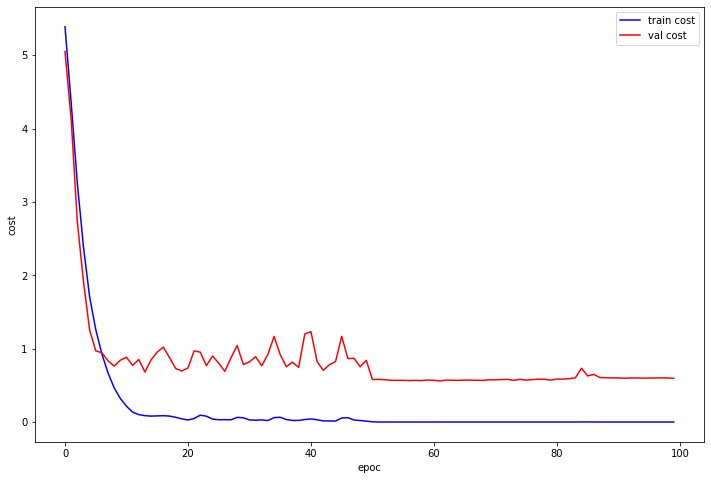

In [27]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(epoc*2),train_cost_array,c='b',label='train cost')
plt.plot(np.arange(epoc*2),val_cost_array,c='r',label='val cost')
plt.xlabel('epoc')
plt.ylabel('cost')
plt.legend()



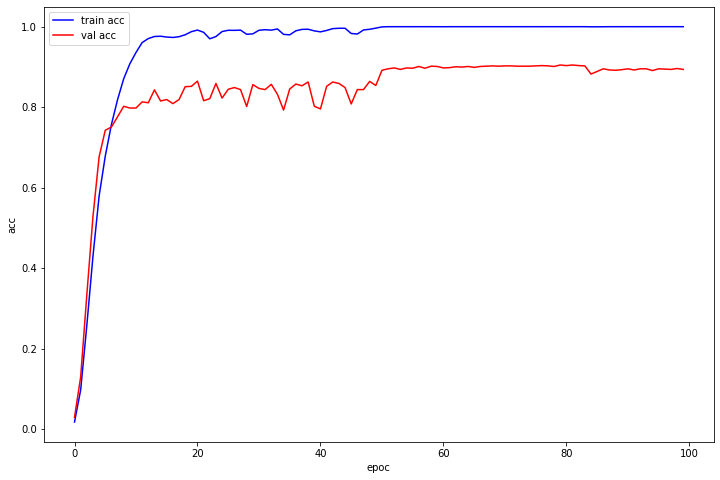

In [28]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(epoc*2),train_acc_array,c='b',label='train acc')
plt.plot(np.arange(epoc*2),val_acc_array,c='r',label='val acc')
plt.xlabel('epoc')
plt.ylabel('acc')

plt.legend()

In [30]:
test_cost=0
test_acc=0
resnet.eval()
with torch.no_grad():
    for img,lab in test_dataloader:
        img=img.to(device)
        lab=lab.to(device)
        y_hat=resnet(img)
        res_loss=loss(y_hat,lab)
        test_cost=test_cost+res_loss*len(lab)
        test_acc=test_acc+(y_hat.argmax(1)==lab).sum()
print(f"testcost: {test_cost},acc count: {test_acc},acc: {test_acc/len(test_dataset)}\n")

testcost: 651.3525390625,acc count: 1251,acc: 0.909818172454834



In [31]:
torch.save(resnet.state_dict(),'resnet18.pth')